# IPO, AMO and Rainfall Time Series over Sri Lanka and East Africa
* Wenchang Yang (wenchang@prnceton.edu)
* Department of Geosciences, Princeton University

In [72]:
import sys, os, os.path, datetime, glob
import numpy as np, matplotlib.pyplot as plt, pandas as pd, xarray as xr

from climindex import get_climate_index
import xlearn

%matplotlib notebook

## Time series

In [6]:
# params


In [4]:
# data
ipo = get_climate_index('IPO')
ipo = xr.DataArray(ipo, dims='time', coords=[ipo.index]).sel(time=slice(None, '2017'))
ipo

<xarray.DataArray 'IPO' (time: 1968)>
array([ 0.356,  0.026, -0.043, ..., -0.801, -0.916, -1.038])
Coordinates:
  * time     (time) datetime64[ns] 1854-01-31 1854-02-28 1854-03-31 ...

In [12]:
# data
amo = get_climate_index('AMO')
amo = xr.DataArray(amo, dims='time', coords=[amo.index]).sel(time=slice(None, '2017'))
amo

<xarray.DataArray 'AMO' (time: 1944)>
array([0.231, 0.165, 0.236, ..., 0.433, 0.351, 0.363])
Coordinates:
  * time     (time) datetime64[ns] 1856-01-31 1856-02-29 1856-03-31 ...

In [17]:
# data
ds = xr.open_dataset('data/gpcc/precip.mon.total.v7.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1356)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 87.75 87.25 86.75 86.25 ...
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 ...
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 1901-03-01 ...
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Original_Source:  http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm...
    Reference:        Users of the data sets are kindly requested to give fee...
    original_source:  ftp://ftp-anon.dwd.de/pub/data/gpcc/html/fulldata_downl...
    Conventions:      CF 1.0
    References:       http://www.esrl.noaa.gov/psd/data/gridded/data.gpcc.html
    history:          Created 01/2016 based on V7 data obtained via ftp
    title:            GPCC Full Data Reanalysis Version 7 0.5x0.5 Monthly Total
    dataset_title:    Global Precipitation Climatology Centre (GPCC)

In [34]:
# EA MAM rainfall
years = slice('1901', '2013')
lons = slice(40, 52)
lats = slice(12, -10)
da = ds.precip.sel(time=years, lon=lons, lat=lats).isel(time=ds.time.dt.season=='MAM').mean(['lon', 'lat']).pipe(lambda x: x/30).load()
ea = da
da

<xarray.DataArray 'precip' (time: 339)>
array([0.904975, 2.536303, 3.016805, ..., 1.885161, 3.330155, 1.847752],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1901-03-01 1901-04-01 1901-05-01 ...

In [66]:
# Sri Lanka rainfall
years = slice('1901', '2013')
lons = slice(79, 82)
lats = slice(10, 5)
da = ds.precip.sel(time=years, lon=lons, lat=lats).mean(['lon', 'lat']).pipe(lambda x: x/30).load()
sriLanka = da
da

<xarray.DataArray 'precip' (time: 1356)>
array([4.616567, 2.736567, 3.0071  , ..., 4.576408, 6.4208  , 3.928325],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 1901-03-01 ...

<IPython.core.display.Javascript object>


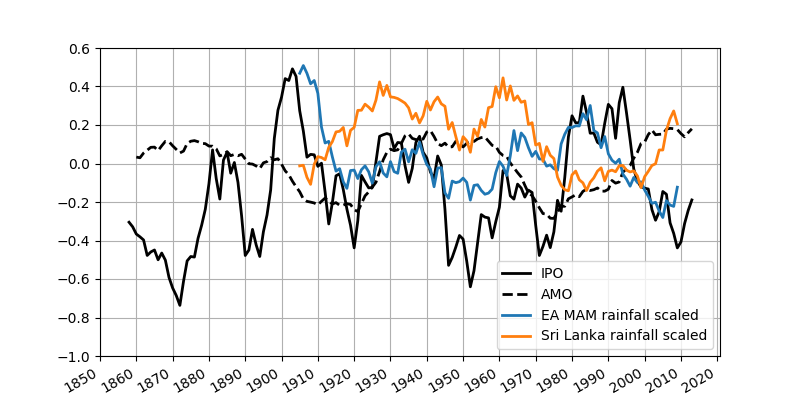

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [67]:
fig = plt.figure(figsize=(8,4))
ipo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().plot(label='IPO', color='k')
amo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().plot(label='AMO', color='k', ls='--')
ea.resample(time='AS').mean().pipe(lambda x: x-x.sel(time=slice('1981', '2010')).mean('time')) \
    .pipe(lambda x: x/1.2) \
    .rolling(time=9, center=True, min_periods=9).mean().plot(label='EA MAM rainfall scaled')
sriLanka.resample(time='AS').mean().pipe(lambda x: x-x.sel(time=slice('1981', '2010')).mean('time')) \
    .pipe(lambda x: x/1.5) \
    .rolling(time=9, center=True, min_periods=9).mean().plot(label='Sri Lanka rainfall scaled')

plt.legend(frameon=True)
plt.ylim(-1,.6)
plt.xticks([f'{year}' for year in range(1850, 2025, 10)])
plt.grid('on')

## Correlation coefficients

In [75]:
years = slice('1905', '2009')
x = ipo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
y = ea.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
r = y.learn.regress(x, normalize_xy=True).coef_da.item()
print(f'r(EA_MAM, IPO) = {r:.2f}')

r(EA_MAM, IPO) = 0.51


In [76]:
years = slice('1905', '2009')
x = ipo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
y = sriLanka.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
r = y.learn.regress(x, normalize_xy=True).coef_da.item()
print(f'r(SriLanka, IPO) = {r:.2f}')

r(SriLanka, IPO) = -0.22


In [77]:
years = slice('1905', '2009')
x = amo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
y = ea.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
r = y.learn.regress(x, normalize_xy=True).coef_da.item()
print(f'r(EA_MAM, AMO) = {r:.2f}')

r(EA_MAM, AMO) = -0.56


In [78]:
years = slice('1905', '2009')
x = amo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
y = sriLanka.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
r = y.learn.regress(x, normalize_xy=True).coef_da.item()
print(f'r(SriLanka, AMO) = {r:.2f}')

r(SriLanka, AMO) = 0.40


In [79]:
years = slice('1901', '2013')
x = ipo.resample(time='AS').mean().sel(time=years)
y = ea.resample(time='AS').mean().sel(time=years)
r = y.learn.regress(x, normalize_xy=True).coef_da.item()
print(f'r(EA_MAM, IPO, inter-annual) = {r:.2f}')

r(EA_MAM, IPO, inter-annual) = 0.18


In [80]:
years = slice('1901', '2013')
x = ipo.resample(time='AS').mean().sel(time=years)
y = sriLanka.resample(time='AS').mean().sel(time=years)
r = y.learn.regress(x, normalize_xy=True).coef_da.item()
print(f'r(SriLanka, IPO, inter-annual) = {r:.2f}')

r(SriLanka, IPO, inter-annual) = 0.12


In [83]:
years = slice('1901', '2013')
x = amo.resample(time='AS').mean().sel(time=years)
y = ea.resample(time='AS').mean().sel(time=years)
r = y.learn.regress(x, normalize_xy=True).coef_da.item()
print(f'r(EA_MAM, AMO, inter-annual) = {r:.2f}')

r(EA_MAM, AMO, inter-annual) = -0.13


In [82]:
years = slice('1901', '2013')
x = amo.resample(time='AS').mean().sel(time=years)
y = sriLanka.resample(time='AS').mean().sel(time=years)
r = y.learn.regress(x, normalize_xy=True).coef_da.item()
print(f'r(SriLanka, AMO, inter-annual) = {r:.2f}')

r(SriLanka, AMO, inter-annual) = 0.14


## Reconstruction of EA MAM rainfall

In [117]:
years = slice('1905', '2009')
x1 = ipo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
x2 = amo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
xx = xr.concat([x1,x2], pd.Index(['IPO', 'AMO'], name='feature')).transpose()
y = ea.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
m = y.learn.regress(xx)
beta_ipo = m.coef_da.sel(feature='IPO').item()
beta_amo = m.coef_da.sel(feature='AMO').item()
beta0 = m.intercept_da.item()

<IPython.core.display.Javascript object>


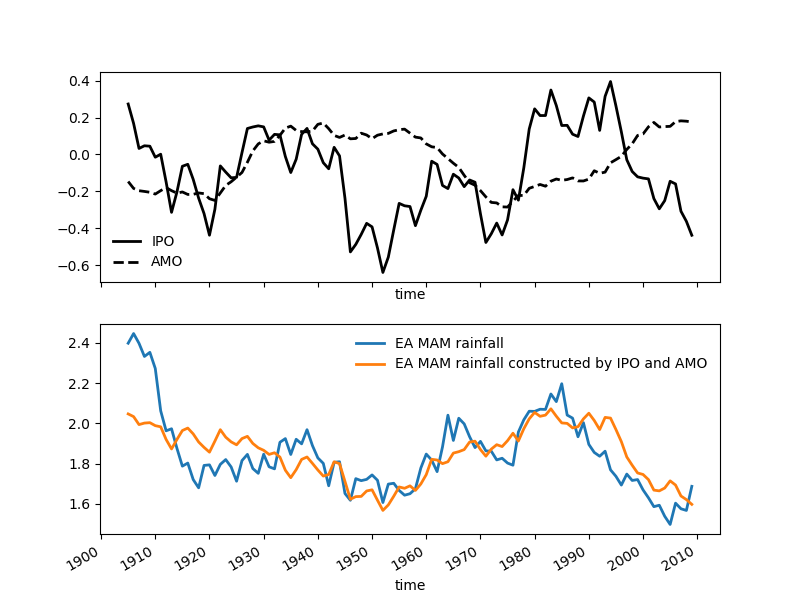

([<matplotlib.axis.XTick at 0x2b7bb2da4828>,
 <a list of 12 Text xticklabel objects>)

In [131]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True)

plt.sca(axes[0])
x1.plot(label='IPO', color='k')
x2.plot(label='AMO', color='k', ls='--')
plt.legend()


plt.sca(axes[1])
y.plot(label='EA MAM rainfall')
y_ = beta0 + beta_ipo * x1 + beta_amo * x2
y_.plot(label='EA MAM rainfall constructed by IPO and AMO')

plt.legend()
plt.xticks([f'{year}' for year in range(1900, 2020, 10)])

In [133]:
print('beta_ipo =', beta_ipo)
print('beta_amo =', beta_amo)
print('Var explained:', y_.var().item()/y.var().item())


beta_ipo = 0.34796043063374604
beta_amo = -0.6215521945581297
Var explained: 0.48786846167307424


## Reconstruction of Sri Lanka rainfall

In [134]:
years = slice('1905', '2009')
x1 = ipo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
x2 = amo.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
xx = xr.concat([x1,x2], pd.Index(['IPO', 'AMO'], name='feature')).transpose()
y = sriLanka.resample(time='AS').mean().rolling(time=9, center=True, min_periods=9).mean().sel(time=years)
m = y.learn.regress(xx)
beta_ipo = m.coef_da.sel(feature='IPO').item()
beta_amo = m.coef_da.sel(feature='AMO').item()
beta0 = m.intercept_da.item()

<IPython.core.display.Javascript object>


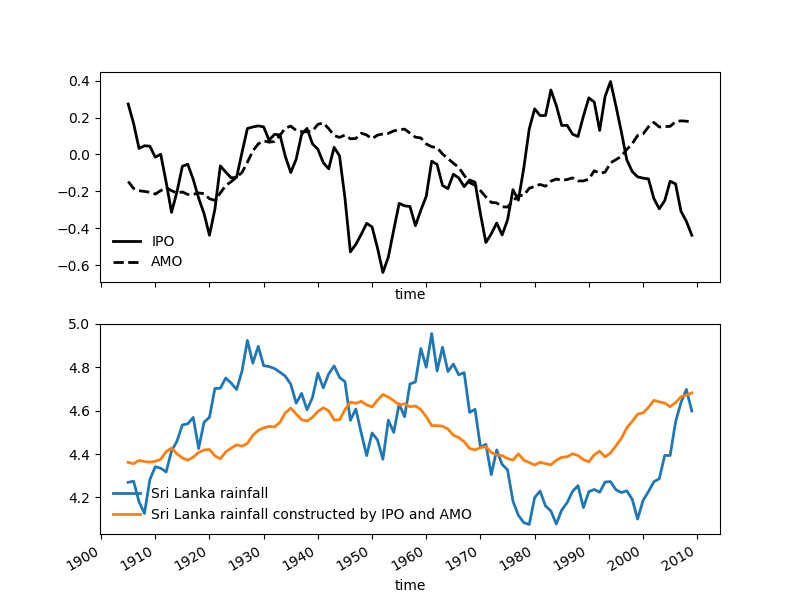

([<matplotlib.axis.XTick at 0x2b7bb2f8c780>,
 <a list of 12 Text xticklabel objects>)

In [136]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True)

plt.sca(axes[0])
x1.plot(label='IPO', color='k')
x2.plot(label='AMO', color='k', ls='--')
plt.legend()


plt.sca(axes[1])
y.plot(label='Sri Lanka rainfall')
y_ = beta0 + beta_ipo * x1 + beta_amo * x2
y_.plot(label='Sri Lanka rainfall constructed by IPO and AMO')

plt.legend()
plt.xticks([f'{year}' for year in range(1900, 2020, 10)])

In [137]:
print('beta_ipo =', beta_ipo)
print('beta_amo =', beta_amo)
print('Var explained:', y_.var().item()/y.var().item())


beta_ipo = -0.1652964865046119
beta_amo = 0.6256247347043743
Var explained: 0.18770306155327818


In [8]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js">
</script>